In [158]:
############# WORK IN PROGRESS #################
# goal is to use several K optimization methods 
# to determine K for our stat arb class
# look in each cluster and selct a pair 

In [558]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import seaborn as sns
from statsmodels.tsa.api import adfuller
import yahoo_finance as yf
import pandas_datareader as pdr

In [559]:
# Modify some settings
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 150

pd.options.display.max_rows = 20
pd.options.display.max_columns = 15

In [560]:
data = pd.read_csv('~/k_means/Data/sp_financials.csv')

In [561]:
data = data.drop(['SEC_Filings', 'Sector', 'Name'], axis=1)

In [562]:
symbol = data['Symbol']

In [563]:
data = data.set_index('Symbol')

In [564]:
data = data.fillna(0)

In [565]:
cols = ['Price', 'Price/Earnings', 'Dividend_Yield', 'Earnings/Share',
       '52_Week_Low', '52_Week_High', 'Market_Cap', 'EBITDA', 'Price/Sales',
       'Price/Book']
data = data[['Price', 'Price/Earnings', 'Dividend_Yield', 'Earnings/Share',
       '52_Week_Low', '52_Week_High', 'Market_Cap', 'EBITDA', 'Price/Sales',
       'Price/Book']]
data.head()

,Price,Price/Earnings,Dividend_Yield,Earnings/Share,52_Week_Low,52_Week_High,Market_Cap,EBITDA,Price/Sales,Price/Book
Symbol,,,,,,,,,,
MMM,222.89,24.31,2.332862,7.92,259.77,175.490,1.387210e+11,9.048000e+09,4.390271,11.34
AOS,60.24,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,6.010000e+08,3.575483,6.35
ABT,56.27,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,5.744000e+09,3.740480,3.19
ABBV,108.48,19.41,2.499560,3.29,125.86,60.050,1.813860e+11,1.031000e+10,6.291571,26.14
ACN,150.51,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,5.643228e+09,2.604117,10.62


In [566]:
# standardize data to have mean ~0 and var of 1

data_std = StandardScaler().fit_transform(data)

# save for later in df form
ds = pd.DataFrame(data_std, columns=cols)
ds = ds.set_index(symbol)

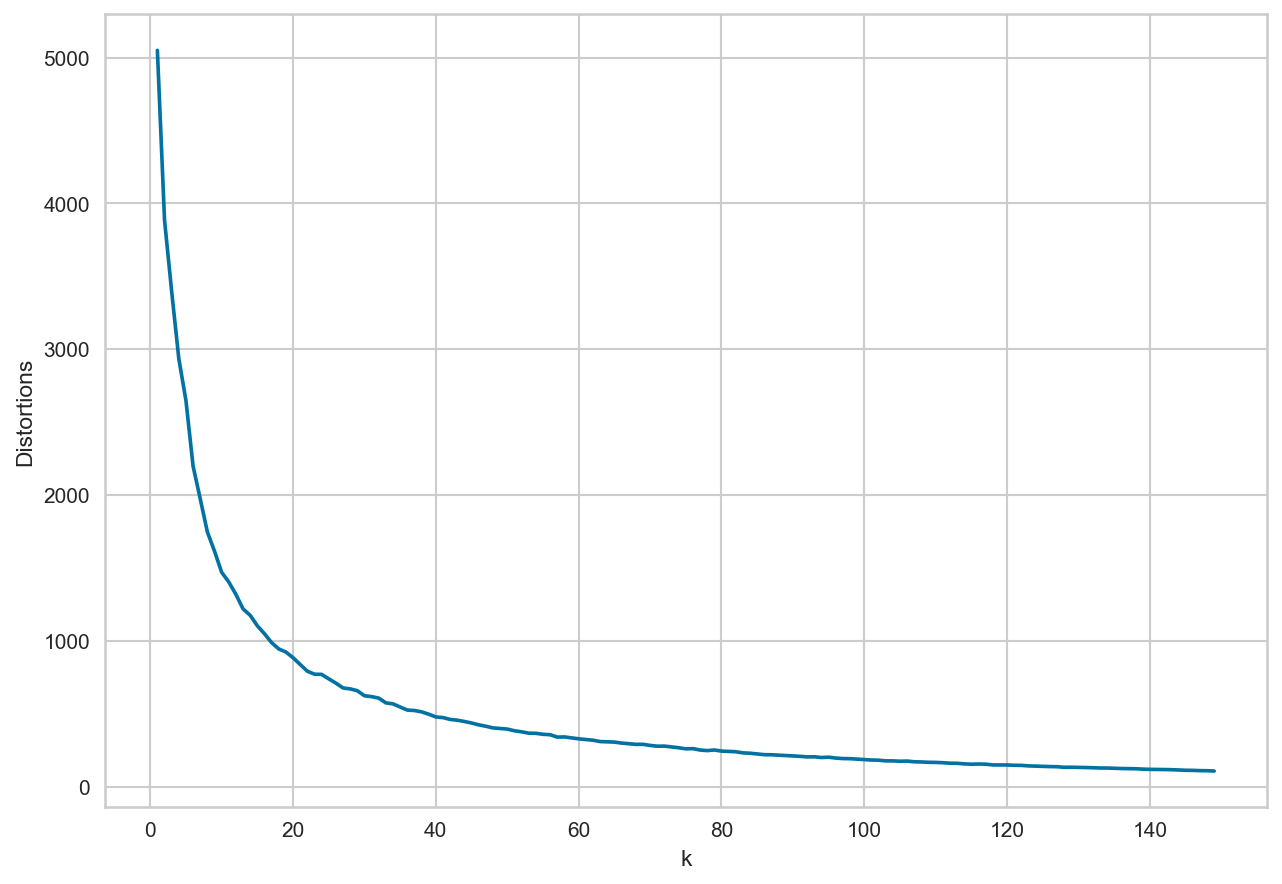

In [567]:
# Elbow Method to find K
# Here we want to find within-cluster sum of squares as a function of the number of clusters 
# we want to choose the number of clusters so that adding another doesnt cause a significant
# improvement to the total within-cluster sum of squares
# inertia_ attribute can show this

def elbow(features, range_max):
    distortions = []
    K = range(1,range_max)
    for k in K:
        model = KMeans(n_clusters=k)
        model.fit_predict(features)
        distortions.append(model.inertia_)
        
    return K, distortions

k, d = elbow(data_std, 150)

plt.plot(k, d, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.show()


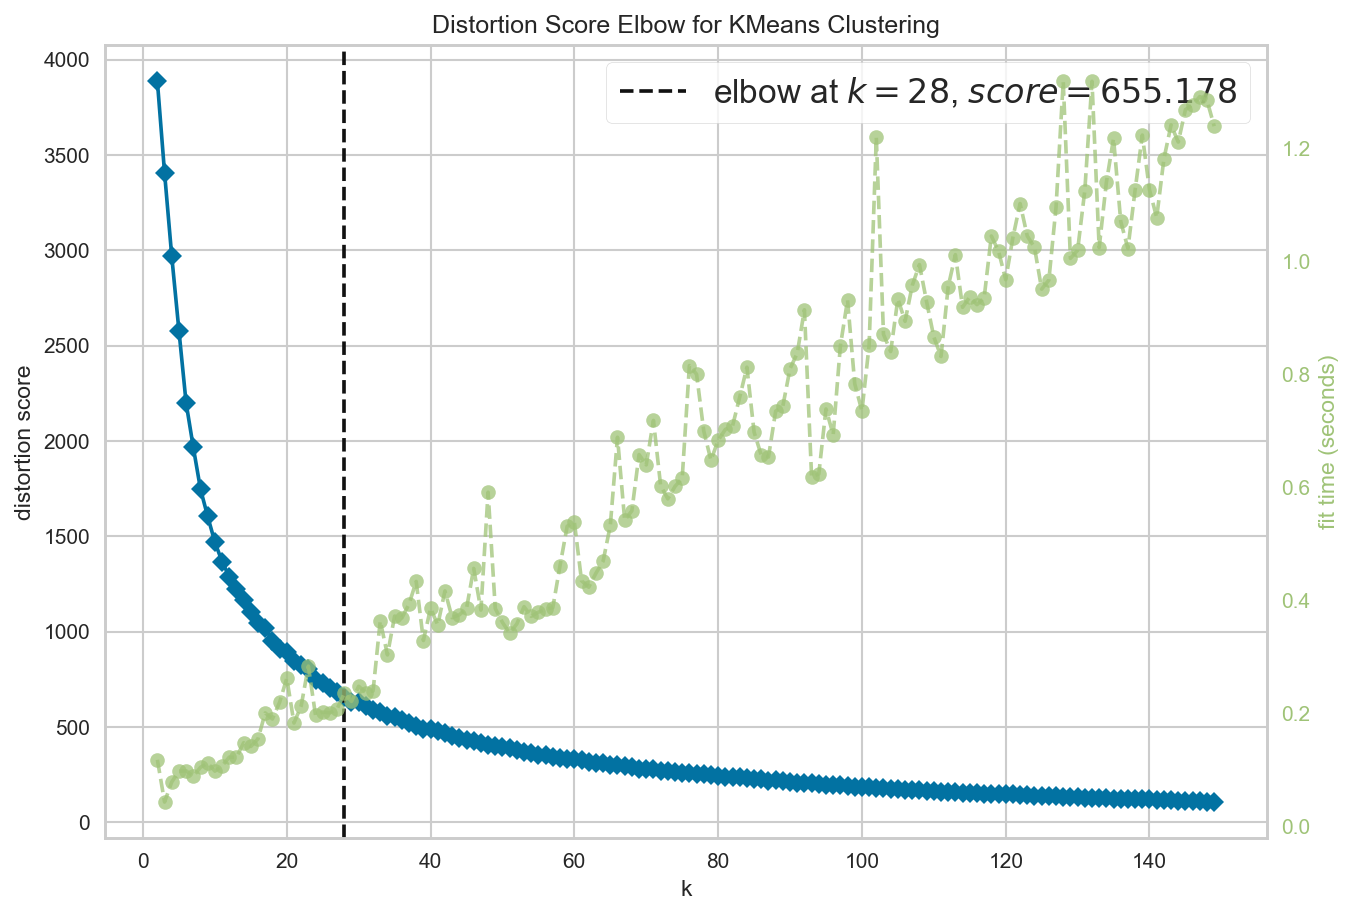

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [569]:
# different visualization
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,150))
visualizer.fit(data_std)
visualizer.show()

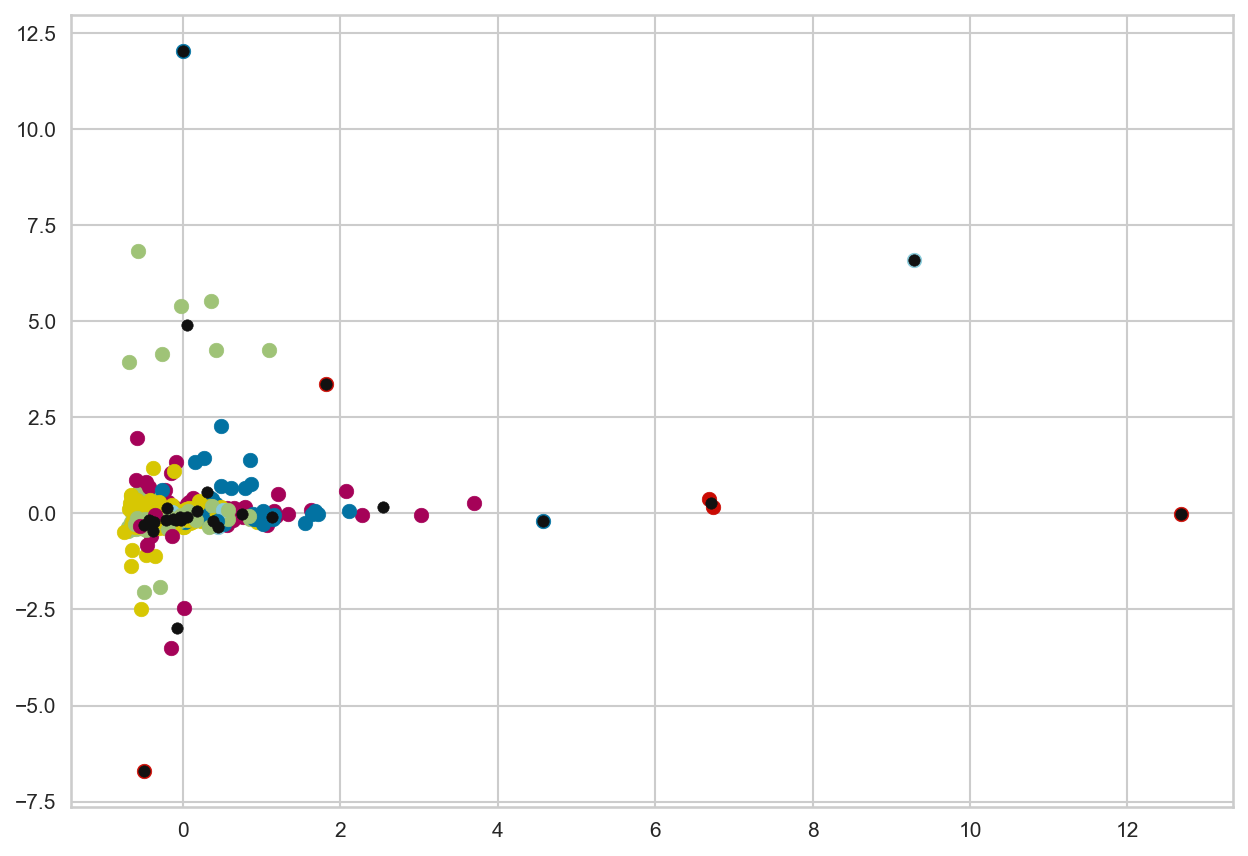

In [571]:
# implement model with K found above
kmeans = KMeans(n_clusters = 28)
label = kmeans.fit_predict(data_std)
u_labels = np.unique(label)

centroids = kmeans.cluster_centers_

for i in u_labels:
    plt.scatter(data_std[label == i , 0] , data_std[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 30, color = 'k')
plt.show()

<AxesSubplot:ylabel='Symbol'>

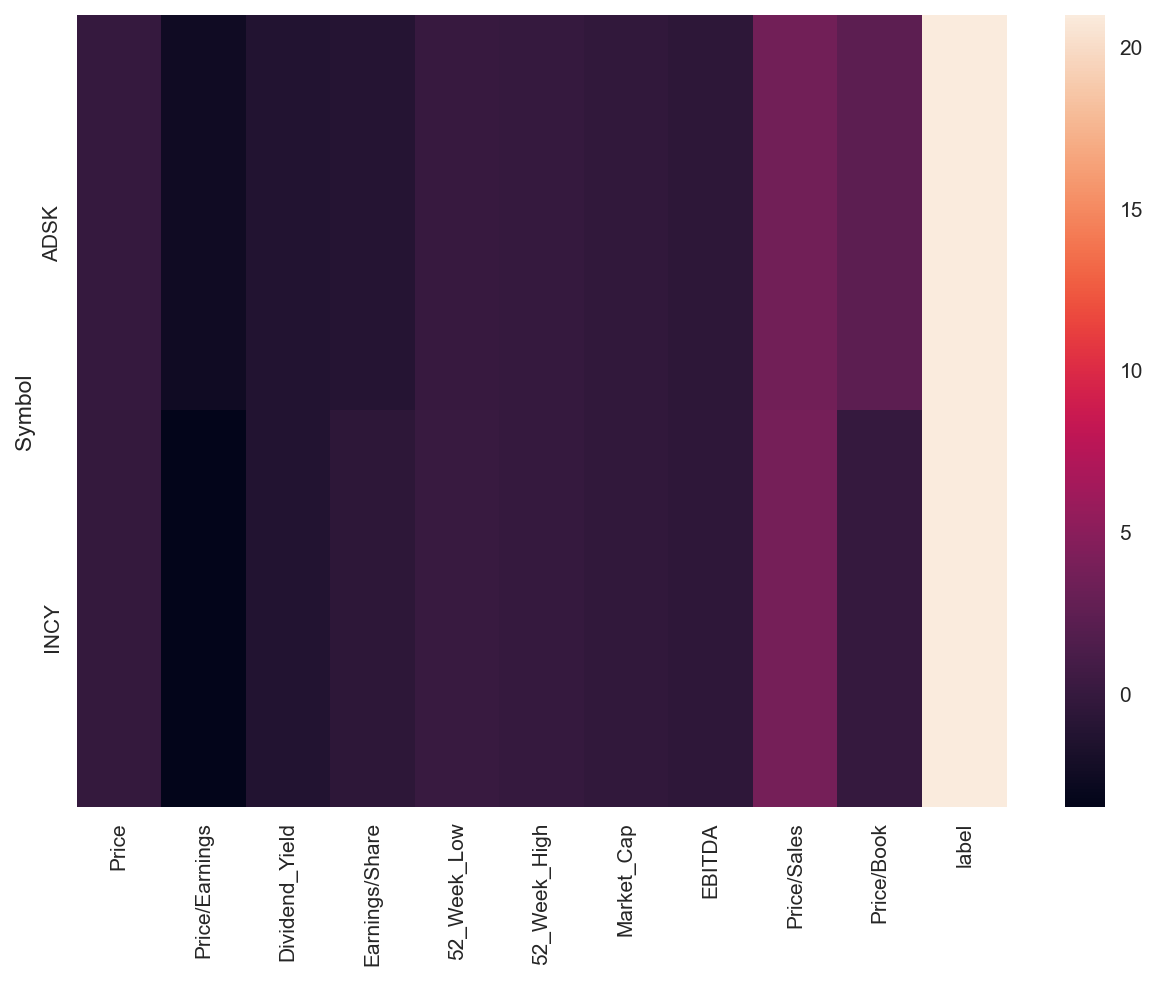

In [588]:
ds['label'] = label
# lets choose cluster 21 as an example and choose the stocks for our model
cluster = ds[ds['label'] == 21]

sns.heatmap(cluster)


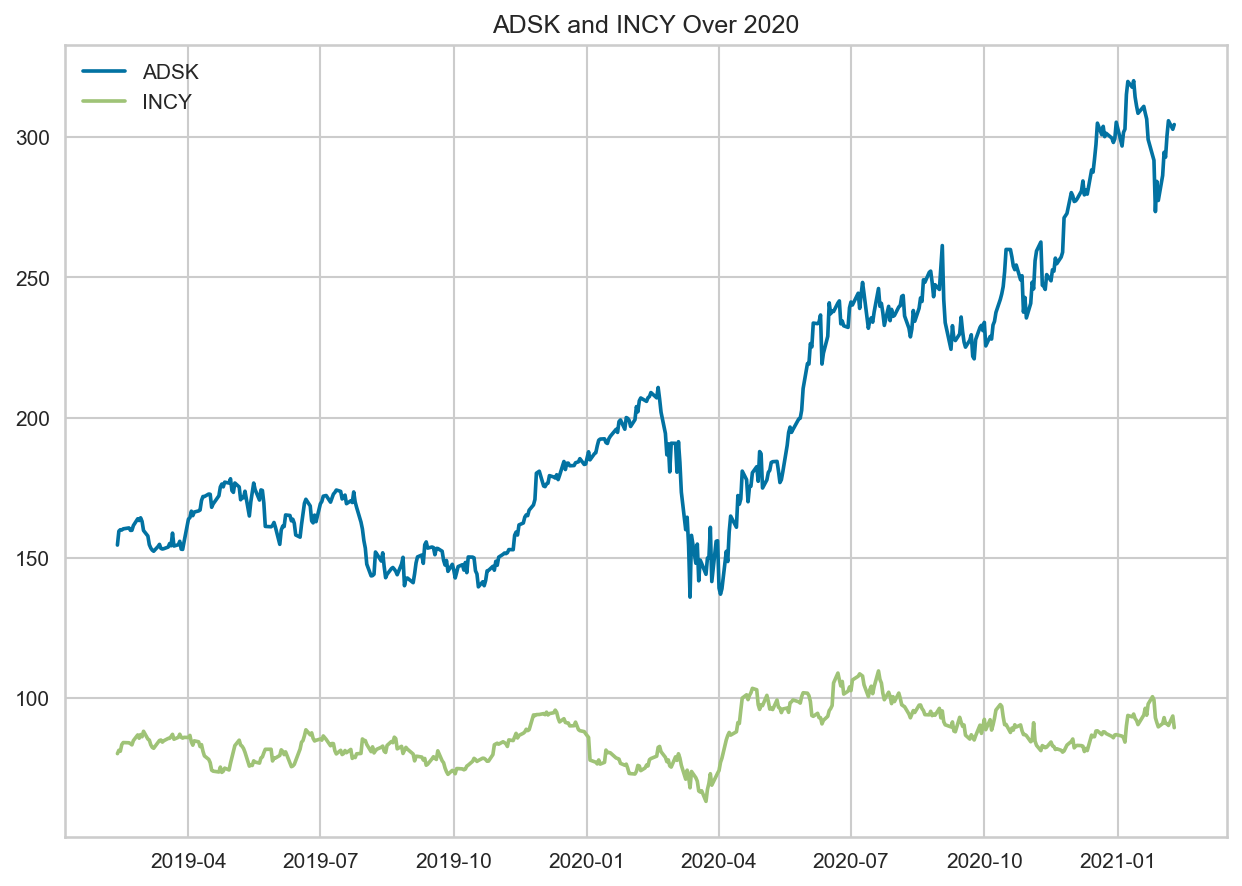

In [589]:
# pull the stock info from yahoo
start = '2019-02-09'
end = '2021-02-09'
name_1 = "ADSK"
name_2 = "INCY"
s1 = pdr.get_data_yahoo(name_1, start, end)
s2 = pdr.get_data_yahoo(name_2, start, end)

plt.plot(s1['Close'],label=name_1)
plt.plot(s2['Close'],label=name_2)
plt.title(name_1 + ' and ' + name_2 + ' Over 2020')
plt.legend(loc=0)
plt.show()

<AxesSubplot:>

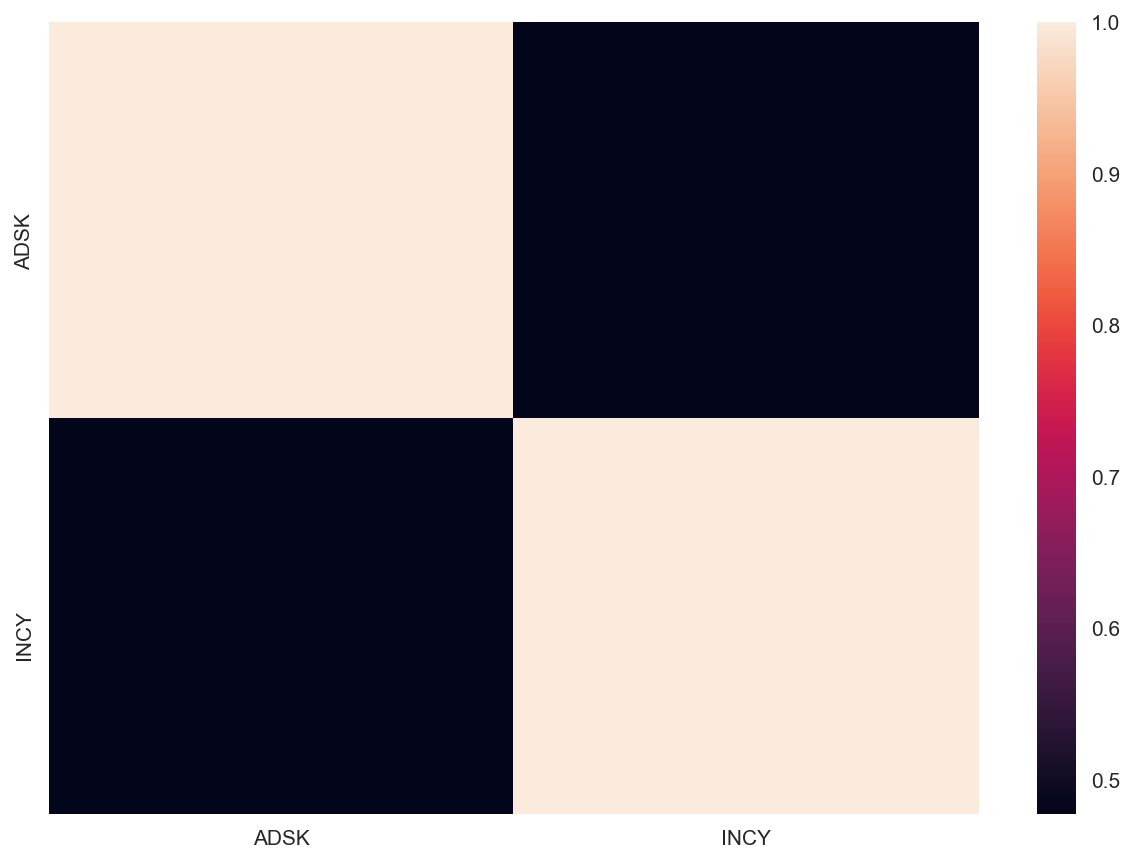

In [590]:
# check correlation
stocks = pd.DataFrame()
stocks[name_1] = s1['Close']
stocks[name_2] = s2['Close']
sns.heatmap(stocks.corr())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


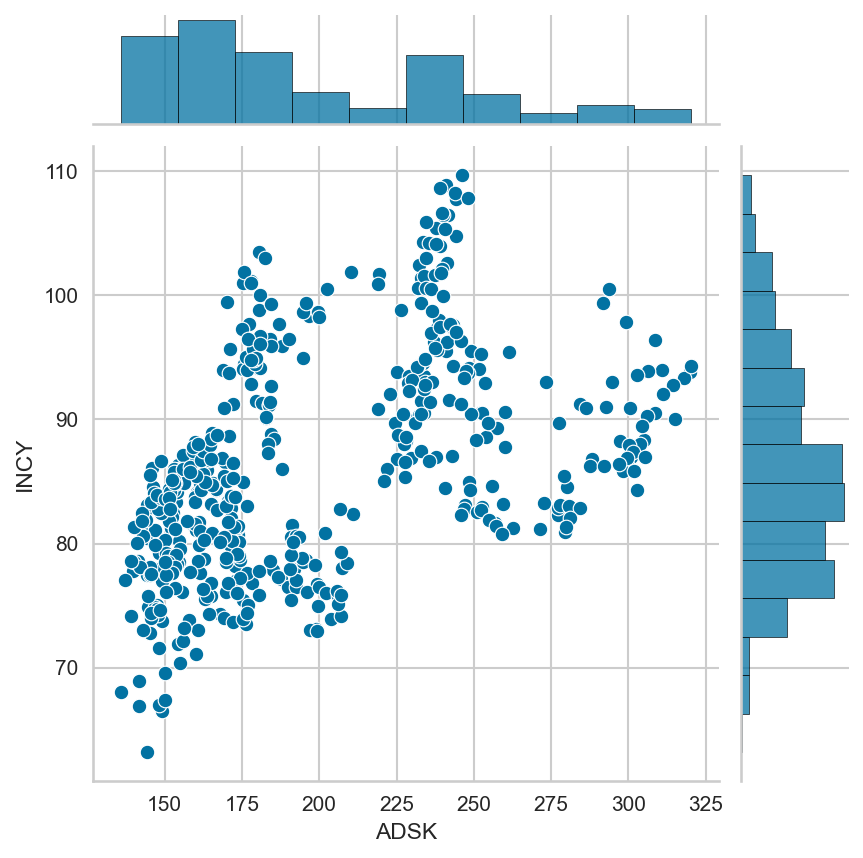

In [591]:
sns.jointplot(stocks[name_1], stocks[name_2])
plt.show()

In [592]:
# create spread and perform ADF test
stocks['spread'] = stocks[name_1] - stocks[name_2]
adf=adfuller(stocks['spread'])

adf

(-0.015629056301079268,
 0.9572203306377101,
 2,
 501,
 {'1%': -3.443470002903981,
  '5%': -2.867326248740681,
  '10%': -2.569851849873108},
 2855.3806209730146)

In [594]:
# find adf significance 
# note: this is without hedge ratio implemented

if adf[0] < adf[4]['1%']:
    print('Spread is Cointegrated at 1% Significance Level')
elif adf[0] < adf[4]['5%']:
    print('Spread is Cointegrated at 5% Significance Level')
elif adf[0] < adf[4]['10%']:
    print('Spread is Cointegrated at 10% Significance Level')
else:
    print('Spread is not Cointegrated')

Spread is not Cointegrated
